In [1]:
import os
import csv
import time
import imageio
import shutil
import scipy.io
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.image import imread
from scipy.integrate import quad

import solver.conditions as conditions
import solver.utils as utils
import solver.pinn as pinn
import solver.pde as pde
import solver.siren as siren
import solver.geometry as geometry
import solver.timedomain as timedomain
import solver.visualizations as visualizations

import warnings
warnings.filterwarnings("ignore")

In [2]:
def initial_condition_function(x):
    return torch.sin(torch.pi * torch.tensor(x))

def boundary_condition_function(x, t):
    return torch.zeros_like(x)

def analytical_solution(x, t, alpha, L):
    x = torch.tensor(x)
    t = torch.tensor(t)
    u = torch.zeros_like(x)

    for n in range(1, 100):
        B_n, _ = quad(lambda x: initial_condition_function(x) * np.sin(n * np.pi * x / L), 0, L)
        u += 2 / L * B_n * torch.sin(n * np.pi * x / L) * torch.exp(-alpha**2 * (n * np.pi / L)**2 * t)
    return u

In [3]:
geom = geometry.Interval(0.0, 1.0)
period = timedomain.TimeDomain(0.0, 0.5)
alpha = 0.5
n = 1000

# Generate initial conditions
initial_conditions = conditions.InitialConditions()
initial_conditions.set_initial_conditions(geom=geom, time=period, 
                                          initial_func=initial_condition_function, 
                                          num_points=n, random=False, device="cuda:0")

# Generate boundary conditions
boundary_conditions = conditions.BoundaryConditions()
boundary_conditions.set_boundary_conditions(geom=geom, time=period, 
                                            boundary_func=boundary_condition_function, 
                                            num_points=n, random=False, device="cuda:0")

pde_heat = pde.PDE('heat', alpha=alpha)

# Generate equation
equation = conditions.Equation()
equation.set_equation(pde = pde_heat, geom=geom, time=period, 
                      num_points=n, random=False, device="cuda:0")

# Generate test
test = conditions.Test()
test.set_test(geom=geom, time=period, num_points=n, random=False, device="cuda:0")

problem = conditions.Problem(initial_conditions, boundary_conditions, 
                             equation, test, geom, period, alpha=alpha)

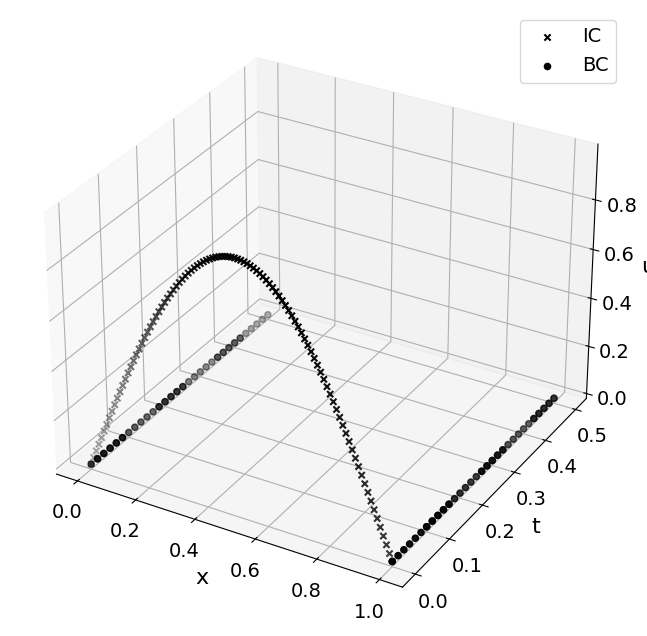

In [4]:
visualizations.solution_surface_plot(problem, None, 'architecture', 14)

### Loop architecture search

In [5]:
def save_results_to_csv(results, filename):
    keys = results.keys()
    with open(filename, 'w', newline='') as output_file:
        dict_writer = csv.DictWriter(output_file, keys)
        dict_writer.writeheader()
        dict_writer.writerows([dict(zip(keys, row)) for row in zip(*results.values())])

In [ ]:
# hidden_layers = np.array([1, 2, 4, 6, 8, 10])
# activations = ['tanh', 'sigmoid', 'sin']
# neurons_in_layer = np.array([1, 4, 8, 16, 32, 64])

hidden_layers = np.array([4])
activations = ['sigmoid']
neurons_in_layer = np.array([32, 64])

weights_dir = 'weights'
utils.create_or_clear_folder(weights_dir)

logs_dir = 'logs'
utils.create_or_clear_folder(logs_dir)

l2_norms = {}

results = defaultdict(list)
results_file = 'arch_results.csv'

for activation in activations:
    for hidden_layer in hidden_layers:
        for neurons in tqdm(neurons_in_layer, desc=f"Activation: {activation}, Layers: {hidden_layer}"):
            if activation == 'sin':
                siren_params = siren.SirenParams(first_omega_0 = 30.0,
                                                 hidden_omega_0 = 30.0,
                                                 outermost_linear = True)
            else:
                siren_params = None

            net_params = utils.NetParams()
            net_params.set_params(input=2,
                                  output=1,
                                  hidden_layers=[int(neurons) for _ in range(hidden_layer)],
                                  epochs=10000,
                                  batch_size=100,
                                  lr=0.003,
                                  activation=activation,
                                  training_mode='train',
                                  regularization='Elastic',
                                  lambda_reg=0.01,
                                  optimizer='Adam', # 'LBFGS', 'Adam' or 'Hybrid'
                                  scheduler=None,
                                  early_stopping=True,
                                  use_rar=False,
                                  use_weights_adjuster=False,
                                  display_interval=100,
                                  model_save_path='models',
                                  output_path='out',
                                  save_loss=True,
                                  initial_weights_path=None,
                                  siren_params=siren_params)

            model = pinn.PINN(problem, net_params, device='cuda:0')
            
            start_time = time.time()
            model.train()
            training_time = time.time() - start_time

            u_pinn = model.predict(problem.test.x, problem.test.t)
            
            solution_pinn = conditions.Solution()
            solution_pinn.set_solution(problem.test.x, problem.test.t, u_pinn)
            
            u_analytical = analytical_solution(problem.test.x.cpu().detach().numpy(), 
                                               problem.time.t1, problem.alpha, 
                                               problem.geom.length()).to('cuda:0')
            
            solution_analytical = conditions.Solution()
            solution_analytical.set_solution(problem.test.x, problem.test.t, u_analytical)

            title = f'model_{len(net_params.hidden_layers)}_{net_params.hidden_layers[0]}_{net_params.activation}'
            
            # Plot of solution
            visualizations.comparison_plot(problem, solution_pinn, solution_analytical, 'architecture', title=title)
            
            # Plot loss
            # visualizations.loss_history_plot(model.get_loss_history(), net_params.output_path)

            l2_norm = (torch.sqrt(torch.sum((u_analytical - u_pinn)**2))/len(u_analytical)).item()
            l2_norms[(activation, hidden_layer, neurons)] = l2_norm
            
			# Save results
            params_count = sum(p.numel() for p in model.net.parameters())
            results['activation'].append(activation)
            results['hidden_layers'].append(hidden_layer)
            results['neurons'].append(neurons)
            results['l2_norm'].append(l2_norm)
            results['training_time'].append(training_time)
            results['params_count'].append(params_count)

            torch.save(model.net.state_dict(), 
                       os.path.join(weights_dir, f'model_{hidden_layer}_{activation}_{neurons}.pt'))
            
            save_results_to_csv(results, results_file)

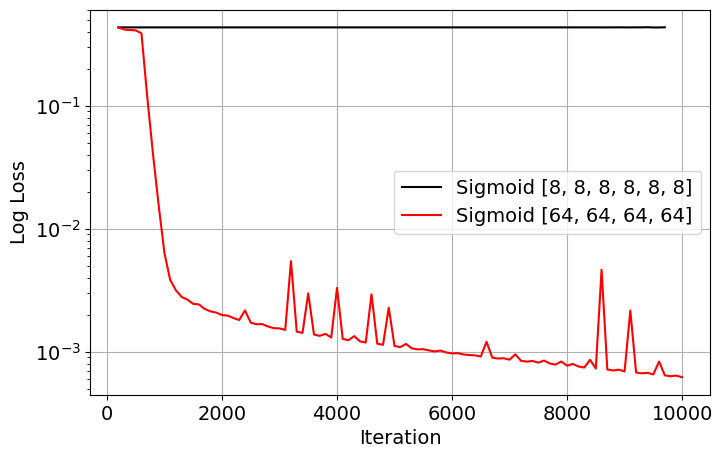

In [16]:
import os
import pandas as pd

data_sigmoid_bad = pd.read_csv(os.path.join(os.getcwd(),'out/HL_6_A_Sigmoid()_N_8_1.csv'))
data_sigmoid_good = pd.read_csv(os.path.join(os.getcwd(),'out/HL_4_A_Sigmoid()_N_32_1.csv'))

plt.figure(figsize=(8, 5))
plt.plot(data_sigmoid_bad.iloc[:, 0], data_sigmoid_bad.iloc[:, 1], label='Sigmoid [8, 8, 8, 8, 8, 8]', c='black')
plt.plot(data_sigmoid_good.iloc[:, 0], data_sigmoid_good.iloc[:, 1], label='Sigmoid [64, 64, 64, 64]', c='red')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Log Loss', fontsize=14)
plt.yscale('log')
# plt.title('Loss for Different Optimizers')
plt.legend(fontsize=14)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=14)
# plt.savefig(os.path.join(os.getcwd(), 'docs', 'tests', 'optimizers', 'optimizer_loss.png'))
plt.show()

In [10]:
results_df = pd.DataFrame(results)
results_df.to_csv('architecture_results.csv', index=False)

In [17]:
def generate_table_fixed_value(results_df, index_col, columns_col, values_col, fixed_col, fixed_value, filename):
    filtered_df = results_df[results_df[fixed_col] == fixed_value]
    pivot_table = filtered_df.pivot(index=index_col, columns=columns_col, values=values_col)
    pivot_table.to_csv(filename)
    print(pivot_table)

In [18]:
results_df = pd.read_csv('arch_results.csv')

In [25]:
fixed_hidden_layers = 1
generate_table_fixed_value(results_df, 'activation', 'neurons', 'l2_norm', 'hidden_layers', fixed_hidden_layers, 'neurons_vs_activation.csv')

neurons           1         4         8         16        32        64
activation                                                            
sigmoid     0.005675  0.001213  0.000158  0.000070  0.000026  0.000036
sin         0.002165  0.000245  0.000019  0.000020  0.000017  0.000044
tanh        0.005752  0.000611  0.000090  0.000033  0.000080  0.000022


In [26]:
fixed_neurons = 8
generate_table_fixed_value(results_df, 'activation', 'hidden_layers', 'l2_norm', 'neurons', fixed_neurons, 'hidden_layers_vs_activation.csv')

hidden_layers        1         2         4         6         8         10
activation                                                               
sigmoid        0.000158  0.000038  0.005503  0.004939  0.004939  0.004913
sin            0.000019  0.000158  0.000374  0.005317  0.005398  0.005604
tanh           0.000090  0.000026  0.000190  0.000067  0.000207  0.000145


In [27]:
fixed_activation = 'sin'
generate_table_fixed_value(results_df, 'hidden_layers', 'neurons', 'l2_norm', 'activation', fixed_activation, 'neurons_vs_hidden_layers.csv')

neurons              1         4         8         16        32        64
hidden_layers                                                            
1              0.002165  0.000245  0.000019  0.000020  0.000017  0.000044
2              0.004904  0.000154  0.000158  0.000191  0.000184  0.002025
4              0.004903  0.000215  0.000374  0.003844  0.004955  0.004951
6              0.002228  0.003155  0.005317  0.004943  0.004957  0.004923
8              0.004928  0.008189  0.005398  0.005044  0.004987  0.004950
10             0.004927  0.004941  0.005604  0.005003  0.004953  0.004899


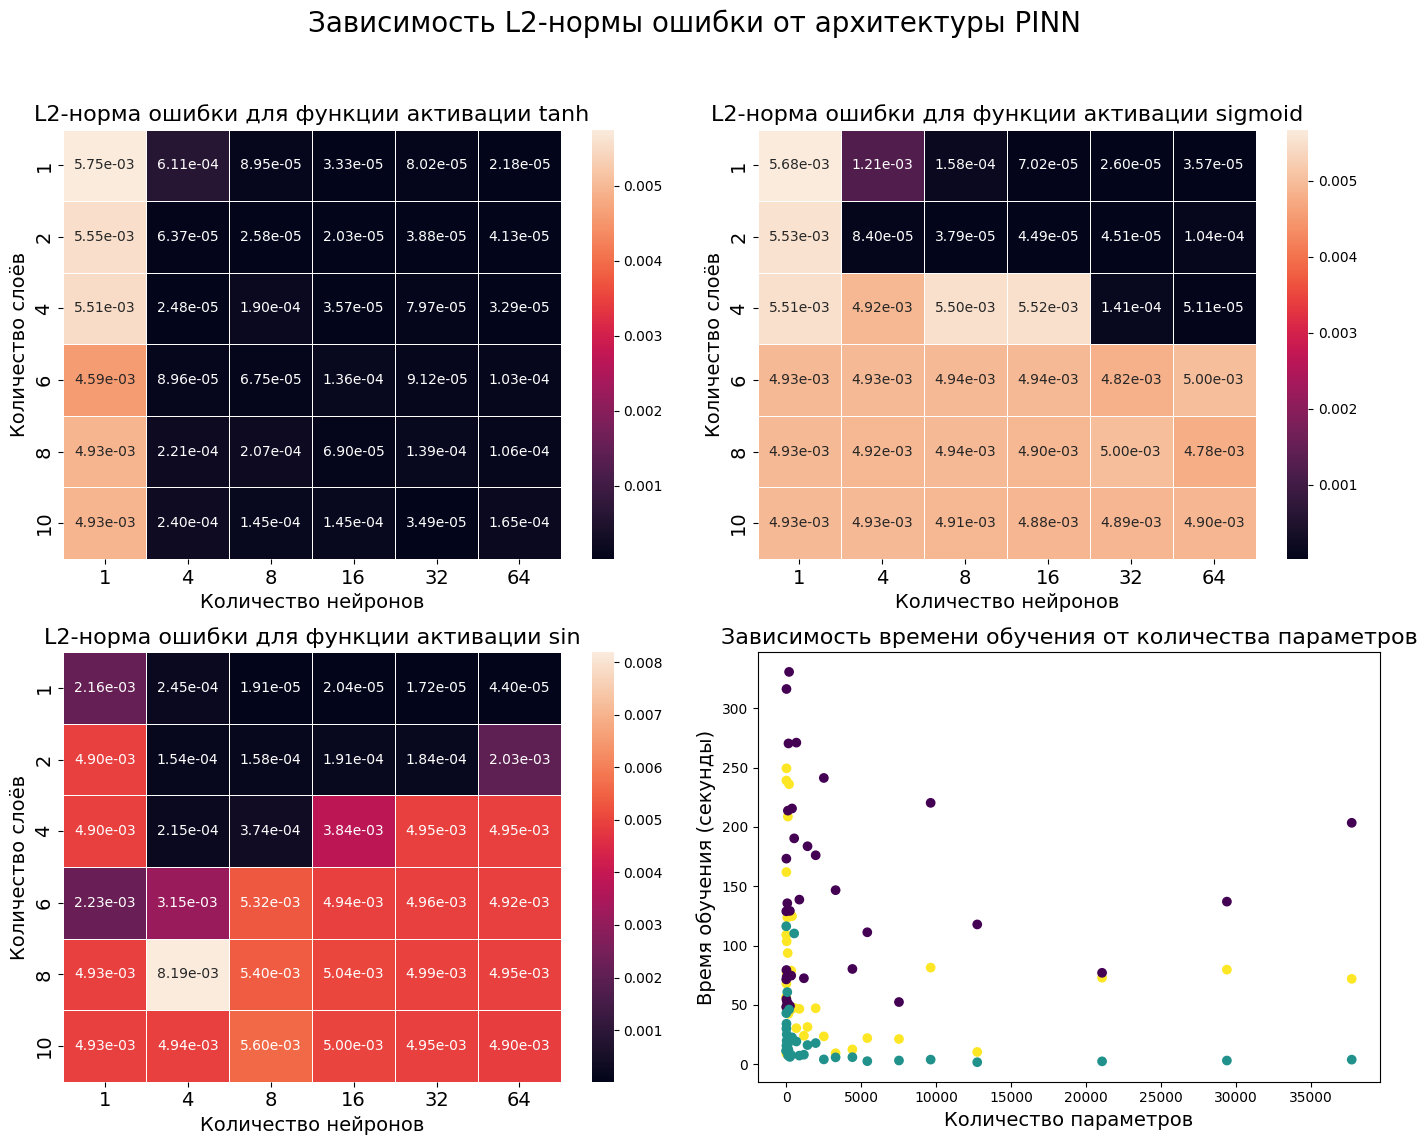

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for i, activation in enumerate(results_df['activation'].unique()):
    data_subset = results_df[results_df['activation'] == activation]
    heatmap_data = data_subset.pivot(index='hidden_layers', columns='neurons', values='l2_norm')
    
    row = i // 2
    col = i % 2
    
    ax = sns.heatmap(heatmap_data, annot=True, fmt=".2e", cmap="rocket", 
                     linewidths=.5, linecolor='white', ax=axes[row, col])
    
    axes[row, col].set_xlabel('Количество нейронов', fontsize=14)
    axes[row, col].set_ylabel('Количество слоёв', fontsize=14)
    axes[row, col].set_title(f'L2-норма ошибки для функции активации {activation}', fontsize=16)

    ax.tick_params(axis='both', which='major', labelsize=14)

# График зависимости времени обучения от количества параметров:
axes[1, 1].scatter(results_df['params_count'], results_df['training_time'], c=results_df['activation'].astype('category').cat.codes)
axes[1, 1].set_xlabel('Количество параметров', fontsize=14)
axes[1, 1].set_ylabel('Время обучения (секунды)', fontsize=14)
axes[1, 1].set_title('Зависимость времени обучения от количества параметров', fontsize=16)

# Гистограмма распределения L2-нормы ошибки:
# sns.histplot(results_df, x='l2_norm', hue='activation', ax=axes[1, 1])
# axes[1, 1].set_xlabel('L2-норма ошибки', fontsize=14)
# axes[1, 1].set_ylabel('Частота', fontsize=14)
# axes[1, 1].set_title('Распределение L2-нормы ошибки', fontsize=16)

# 3D график зависимости L2-нормы от количества слоёв и нейронов:
# from mpl_toolkits.mplot3d import Axes3D
# ax = fig.add_subplot(2, 2, 4, projection='3d')
# for activation in results_df['activation'].unique():
# 	data_subset = results_df[results_df['activation'] == activation]
# 	ax.plot_trisurf(data_subset['neurons'], data_subset['hidden_layers'], data_subset['l2_norm'], cmap='viridis')
# ax.set_xlabel('Количество нейронов', fontsize=14)
# ax.set_ylabel('Количество слоёв', fontsize=14)
# ax.set_zlabel('L2-норма ошибки', fontsize=14)
# ax.set_title('Зависимость L2-нормы от количества слоёв и нейронов', fontsize=16)

fig.suptitle('Зависимость L2-нормы ошибки от архитектуры PINN', fontsize=20)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Optuna search

In [ ]:
import optuna

def objective(trial):
    hidden_layer = trial.suggest_categorical('hidden_layers', [1, 2, 4, 6, 8, 10])
    activation = trial.suggest_categorical('activation', ['tanh', 'sigmoid', 'sin'])
    neurons = trial.suggest_categorical('neurons_in_layer', [1, 4, 8, 16, 32, 64])

    if activation == 'sin':
        siren_params = siren.SirenParams(first_omega_0 = 30.0,
                                            hidden_omega_0 = 30.0,
                                            outermost_linear = True)
    else:
        siren_params = None

    net_params = utils.NetParams()
    net_params.set_params(input=2,
                output=1,
                hidden_layers=[int(neurons) for _ in range(hidden_layer)],
                epochs=5000,
                batch_size=100,
                lr=0.003,
                activation=activation,
                training_mode='train',
                regularization=None,
                lambda_reg=None,
                optimizer='Adam', # 'LBFGS', 'Adam' or 'Hybrid'
                scheduler=None,
                early_stopping=True,
                use_rar=False,
                use_weights_adjuster=False,
                display_interval=100,
                model_save_path='models',
                output_path='out',
                save_loss=True,
                initial_weights_path=None,
                siren_params=siren_params)
    
    model = pinn.PINN(problem, net_params, device='cuda:0')
    model.train()

    u_pinn = model.predict(problem.test.x, problem.test.t)
    u_analytical = analytical_solution(problem.test.x.cpu().detach().numpy(), 
                                       problem.time.t1, problem.alpha, 
                                       problem.geom.length()).to('cuda:0')
    
    l2_norm = torch.sqrt(torch.sum((u_analytical - u_pinn)**2) / len(u_analytical)).item()
    
    return l2_norm

study = optuna.create_study(study_name='pinn_architecture_test',
                            direction='minimize',
                            sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value:', trial.value)
print('Params:')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


: 

### Analysis

In [7]:
import csv

csv_file_path = 'l2_norms.csv'

with open(csv_file_path, 'a', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    
    csv_writer.writerow(['Activation', 'Hidden Layers', 'Neurons', 'L2_norm'])
    
    for key, value in l2_norms.items():
        activation, hidden_layers, neurons = key
        csv_writer.writerow([activation, hidden_layers, neurons, value])

In [29]:
def plot_aggregated_data(data_path, depend_on, fixed_parameter, fixed_value, aggregate_by):
    df = pd.read_csv(data_path)
    filtered_data = df[df[fixed_parameter] == fixed_value]
    unique_values = filtered_data[aggregate_by].unique()

    markers = ['o', 's', '^', 'v', '<', '>', 'd', 'p', 'h', '*']
    
    for i, value in enumerate(unique_values):
        value_data = filtered_data[filtered_data[aggregate_by] == value]
        
        plt.plot(value_data[depend_on], value_data['L2_norm'], 
                 label=f'{value}', 
                 marker=markers[i % len(markers)])
    
    plt.xlabel(depend_on)
    plt.ylabel('L$^2$')
    plt.title(f'Dependence of L$^2$ on {depend_on} at {fixed_parameter}={fixed_value}')
    plt.legend()
    plt.grid(True)
    plt.show()

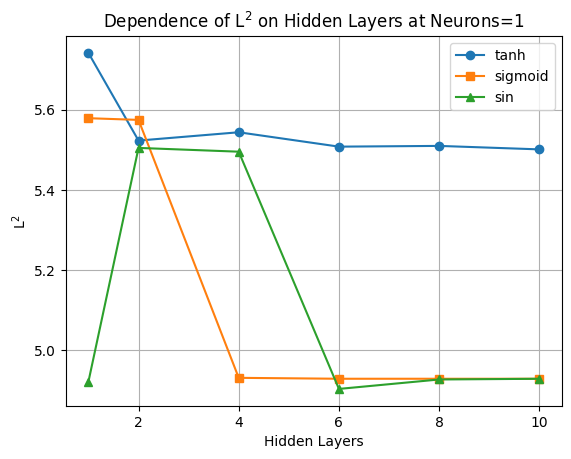

In [31]:
plot_aggregated_data(data_path='l2_norms.csv',
                     depend_on='Hidden Layers',
                     fixed_parameter='Neurons',
                     fixed_value=1,
                     aggregate_by='Activation')